## Importing required libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style = 'darkgrid')

* __Generate SPD matrix using QR factorization__

In [47]:
#MATRIX PARAMETERS (nxn)
n = 100

#rank of the PSD matrix (r<=n), dim = (nxn)
rank = n

#QR factorization
np.random.seed(0)
q, r = np.linalg.qr(np.random.randn(n, n))
q = q[:,:rank]
S = np.diag(np.linspace(0.1,2,rank))
A = q@S@q.T


# eigenvalues and eigenvectors | # eig_val[i] ==> corr. eig_vec[:,i]
eig_val, eig_vec = np.linalg.eig(A)

#dominant eigenvector
u1 = eig_vec[:,0]
u1 /= np.linalg.norm(u1,2)
u1

array([ 5.95678807e-02,  8.79119596e-02,  1.74171452e-01,  4.74063727e-02,
       -7.59859150e-03, -6.95500925e-02,  1.02321596e-01, -5.88727101e-03,
       -4.43838201e-02,  1.41737747e-01,  1.10768579e-01,  4.27347726e-02,
        9.12352899e-02, -7.01929660e-02,  1.01649010e-01, -1.02743452e-02,
        2.66072303e-02,  1.77850288e-01, -4.82777251e-02,  1.59796684e-01,
        8.26166052e-02, -1.68298086e-01,  1.17259587e-01,  1.60634268e-01,
        3.01764603e-02,  7.91187060e-02, -1.76134968e-01, -1.91251221e-01,
       -5.30363345e-02, -3.57507041e-03, -5.15354435e-03,  3.65613721e-02,
        1.05770165e-04, -3.18945596e-02,  1.20173090e-01,  2.23367685e-01,
       -1.06799014e-01, -1.32455133e-01,  7.28166344e-02, -5.36351386e-03,
       -1.11510959e-01, -2.85144155e-02, -8.78103132e-03, -2.21473165e-01,
       -1.69459410e-01, -6.67400265e-02, -6.46480896e-02,  9.42538598e-02,
       -7.17308850e-02,  9.48868963e-02,  4.92410953e-02,  6.34944404e-02,
        1.01273777e-01,  

## Deterministic Power method 

### 1) Without momentum

In [48]:
#Initialization
np.random.seed(0)
x = np.random.rand(A.shape[1])


#max iterations
max_iters=10000

def det_power(A, x, max_iters, u1):
    
    x /= np.linalg.norm(x,2)
    res = []
    res.append(1 - (x.dot(u1))**2)
    for i in range(max_iters):

        # update equation for power iteration without momentum
        x = A@x
        
#         print(x)
        #scaling
        x /= np.linalg.norm(x,2)
#         print(x)
        #residual
        res.append(1 - (x.dot(u1))**2)
#     print(f'Eigenvector: {x}')
    return res

Res_det_power = det_power(A, x, max_iters, u1)

### 2) With momentum

In [50]:
#Initialization
np.random.seed(0)
x0 = np.random.rand(A.shape[0])

#momentum
beta = (eig_val[1]**2)/4

#max iterations
max_iters=10000

def det_power_with_mom(A, x0, beta, max_iters, u1):
    
        x0 /= np.linalg.norm(x0,2)
        x = x0
        x0 = 0
        res = []
        res.append(1 - (x.dot(u1))**2)
        for i in range(max_iters):
            
            # update equation for power iteration with momentum
            x, x0 = A@x - beta*x0, x
            
            #scaling
            z = np.linalg.norm(x,2)
            x /= z
            x0 /= z
            
            #residual
            res.append(1 - (x.dot(u1))**2)
#         print(f'Eigenvector: {x}')
        return res
    
Res_det_power_with_mom = det_power_with_mom(A, x0, beta, max_iters, u1)

# Oja's method

In [55]:
#Initialization
np.random.seed(0)
x = np.random.rand(A.shape[1])

#max iterations
max_iters=10000

def oja(A, x, u1,n_samples, batch_size, max_iters, beta):
    x = x/np.linalg.norm(x,2)
    res = []
    res.append(1 - (x.dot(u1))**2)
    for i in range(max_iters):
        
        #Modified sampling with X ~ N(0, A)
        #################################################################################
#         batch = np.zeros((A.shape[1],A.shape[1]))
#         for j in range(batch_size):
#             X = np.random.multivariate_normal(np.zeros((A.shape[1])), A, batch_size)
#             batch += X@X.T/batch_size
        #################################################################################
        
        # Sampling without replacement
        batch_id = np.random.choice(n_samples, batch_size, replace=False)
        batch = A[batch_id, :]
        
        # update equation for Oja's method
        x = 1.0 / batch_size * batch.T.dot(batch.dot(x)) 
        
        #scaling
        x /= np.linalg.norm(x,2)

        #residual
        res.append(1 - (x.dot(u1))**2)
#     print(f'Eigenvector: {x}')
    return res
res_oja = oja(A, x, u1, n_samples=A.shape[0], batch_size=A.shape[0], max_iters=10000, beta=beta)

## Stochastic power method with momentum (Oja + Momentum)

In [56]:
#Initialization
np.random.seed(0)
x = np.random.rand(A.shape[1])

#momentum
beta = (eig_val[1]**2)/4


def stoc_power_with_mom(A, x, u1, n_samples, batch_size, max_iters, beta):
    
    x = x/np.linalg.norm(x,2)
    x0 = 0
    res = []
    res.append(1 - (x.dot(u1))**2)
    for i in range(max_iters):
        
        #Modified sampling 
        #################################################################################
#         batch = np.zeros((A.shape[1],A.shape[1]))
#         for j in range(batch_size):
#             X = np.random.multivariate_normal(np.zeros((A.shape[1])), A).reshape(-1,1)
#             batch += X@X.T
        #################################################################################
        
        # Sampling without replacement
        batch_id = np.random.choice(n_samples, batch_size, replace=False)
        batch = A[batch_id, :]
        x, x0 = 1.0 / batch_size * batch.T.dot(batch.dot(x)) - beta * x0, x

        z = np.linalg.norm(x,2)
        x /= z
        x0 /= z
        res.append(1 - (x.dot(u1))**2)
        
#     print(f'Eigenvector: {x}')
    return res
Res_stoc_power_with_mom = stoc_power_with_mom(A, x, u1, n_samples=A.shape[0], batch_size=A.shape[0], max_iters=10000, beta=beta)

# Convergence Plots

* __Power method__ 

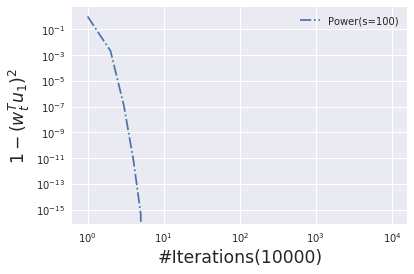

In [52]:
sns.set_style()
plt.plot(range(1,max_iters+2), Res_det_power, label=f'Power(s={A.shape[0]})', linestyle='dashdot')
plt.xlabel(f"#Iterations({max_iters})", fontsize = 'xx-large')
plt.ylabel(r"$1 - (w_t^Tu_1)^2$", fontsize = 'xx-large')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

* __Power method with momentum__ 

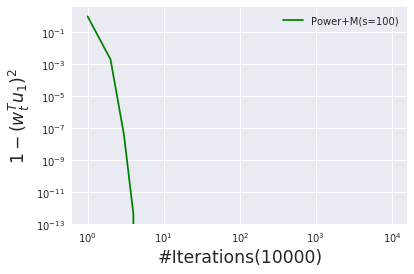

In [57]:
plt.plot(range(1,max_iters+2), Res_det_power_with_mom, label=f'Power+M(s={A.shape[0]})',color='g')
plt.xlabel(f"#Iterations({max_iters})", fontsize = 'xx-large')
plt.ylabel(r"$1 - (w_t^Tu_1)^2$", fontsize = 'xx-large')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

* __Oja's method__ 

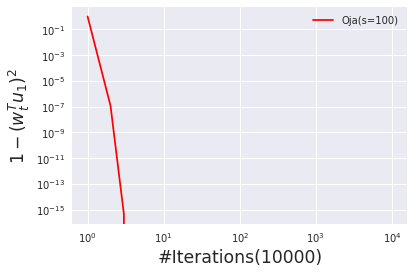

In [59]:
plt.plot(range(1,max_iters+2), res_oja,label=f'Oja(s={A.shape[0]})',color='r')
plt.xlabel(f"#Iterations({max_iters})", fontsize = 'xx-large')
plt.ylabel(r"$1 - (w_t^Tu_1)^2$", fontsize = 'xx-large')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

* __Stochastic Power method with momentum__ 

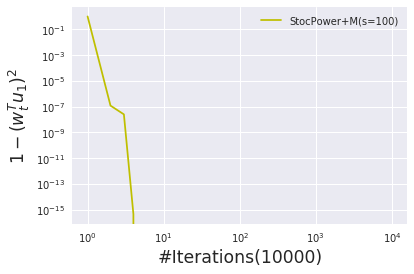

In [60]:
plt.plot(range(1,max_iters+2), Res_stoc_power_with_mom,label=f'StocPower+M(s={A.shape[0]})', color='y')
plt.xlabel(f"#Iterations({max_iters})", fontsize = 'xx-large')
plt.ylabel(r"$1 - (w_t^Tu_1)^2$", fontsize = 'xx-large')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

* __Combined Plots__

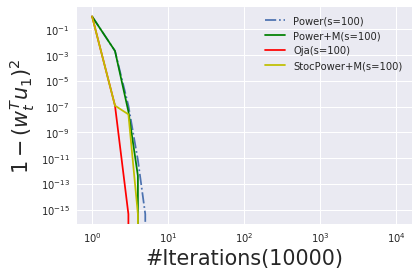

In [62]:
sns.set(style = 'darkgrid')
plt.plot(range(1,max_iters+2), Res_det_power, label=f'Power(s={A.shape[0]})', linestyle='dashdot')
plt.plot(range(1,max_iters+2), Res_det_power_with_mom, label=f'Power+M(s={A.shape[0]})',color='g')
plt.plot(range(1,max_iters+2), res_oja,label=f'Oja(s={A.shape[0]})',color='r')
plt.plot(range(1,max_iters+2), Res_stoc_power_with_mom,label=f'StocPower+M(s={A.shape[0]})', color='y')
plt.xlabel(f"#Iterations({max_iters})", fontsize = 'xx-large')
plt.ylabel(r"$1 - (w_t^Tu_1)^2$", fontsize = 'xx-large')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()